# CMU Machine Learning with Large Datasets

## Homework 3 - Coding 2: Machine Learning at Scale


Note that we've included code that does data loading and preparation for you. You could take a brief look to learn about how to specify a schema when loading data, or just run them all and start from "Part B Begins".

Note that we will not be autograding this notebook because of the open-ended nature of it (although you will have to submit this notebook). To make grading easier and to learn about your thought process, throughout the notebook, we include questions you have to anwswer in your writeup. Whenver this happens, there is a ✰ symbol.


### Start a Spark Session and Install Libraries


In [1]:
# You are highly recommended to select the "PySpark" kernel instead of python kernel,
# Otherwise you need to modify this cell to get pyspark working.

import pyspark
from pyspark.sql import *

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
5,application_1740182129057_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 1

Throughout this assignment, you will be generating plots. `Matplotlib` and other useful Python libraries do not come pre-installed on the cluster. Therefore, you will have to ssh into your master node (think about why it should be the master) using your keypair created earlier and install `matplotlib`. You might have to do this later again for other libraries you use, e.g. `Pandas`.

Run the below cell to ensure you installation was successful. If an error occurs, you might want to double check your installation.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

'''
Note : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nNote : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.\n'

### Data Loading and Preparation

We are hosting the converted full raw Million Song Dataset in a public S3 bucket on AWS: https://us-east-1.console.aws.amazon.com/s3/buckets/10405-spring2025-hw3-msp.

Instead of asking you to download data on your own, we provide the S3 bucket name and script below to load the converted dataset from the S3 Storage for your convenience.

Note that although you can load all chunks of the dataset using `*`, we recommend you only load in a subset while developing so that processing takes shorter time when you are just verifying your ideas.


In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType(
    [StructField('song_hotttnesss', DoubleType(), True),
     StructField('artist_familiarity', DoubleType(), True),
     StructField('artist_hotttnesss', DoubleType(), True),
     StructField('artist_id', StringType(), True),
     StructField('artist_latitude', DoubleType(), True),
     StructField('artist_location', StringType(), True),
     StructField('artist_longitude', DoubleType(), True),
     StructField('artist_name', StringType(), True),
     StructField('title', StringType(), True),
     StructField('danceability', DoubleType(), True),
     StructField('duration', DoubleType(), True),
     StructField('end_of_fade_in', DoubleType(), True),
     StructField('energy', DoubleType(), True),
     StructField('key', DoubleType(), True),
     StructField('key_confidence', DoubleType(), True),
     StructField('loudness', DoubleType(), True),
     StructField('mode', DoubleType(), True),
     StructField('mode_confidence', DoubleType(), True),
     StructField('start_of_fade_out', DoubleType(), True),
     StructField('tempo', DoubleType(), True),
     StructField('time_signature', DoubleType(), True),
     StructField('time_signature_confidence', DoubleType(), True),
     StructField('artist_terms', StringType(), True),
     StructField('artist_terms_freq', StringType(), True),
     StructField('artist_terms_weight', StringType(), True),
     StructField('year', DoubleType(), True)]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#--------------------------------------------------------------------
# Set to False after writing your code and run end-to-end on full data
#--------------------------------------------------------------------
load_subset = False

#----------------------------
# DO NOT change the s3 bucket name below
#----------------------------
s3_bucket_name = '10405-spring2025-hw3-msp'

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 10000 records

Inspect the `df` we just created by running the below cell:


In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

<div align="center">
    <h1>------------------- Part B Begins ------------------- </h1>
</div>


### 2.2.1 Exploratory Data Analysis

Now we have our data mostly ready. It's a good time to take some deeper look to better understand what we are dealing with here.

First, show summary statistics of the features using `.summary()`. Hint: because we have many features, the output might be too long for a single line. The simplest way to resolve this mess is to copy paste the output to some editor (e.g. vscode) and check the result. Another way is you could select only a few features to print at a time so that things could fit into one line.


In [6]:
# YOUR CODE HERE
# Show summary statistics for all columns
df.summary().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------------------+-------------------+------------------+---------------+-----------------+----------------+-----------------+-----------------+------------+------------------+------------------+------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+-------------------+-----------------+
|summary|song_hotttnesss    |artist_familiarity|artist_hotttnesss  |artist_id         |artist_latitude|artist_location  |artist_longitude|artist_name      |title            |danceability|duration          |end_of_fade_in    |energy|key               |key_confidence     |loudness          |mode   

Now looking at the statistics, `danceability` and `energy` appear strange.

✰2.2.1(a) Explain why these features seem problematic in your writeup.

Now we would like to make some histogram plots to inspect the distribution of feature values.

✰2.2.1(b) Plot histograms for `'song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'duration', 'tempo', 'year'`.

Note that one of these features may appear weird.

✰2.2.1(c) Explain what is weird about `year`'s distribution and what might cause this. Describe how you could filter `year` to make its histogram look more balanced. Hint: Choose a threshold and filter the `year` values.

✰2.2.1(d) Do it and include the new plot of this feature into your writeup.

Note: you may want to use the spark magic commands `%matplot plt` to show the plot.


In [7]:
import matplotlib.pyplot as plt

# List of features to plot.
features = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 
            'duration', 'tempo', 'year']

# Convert to Pandas DataFrame (if the data is not huge, otherwise sample).
pdf = df.select(features).toPandas()

# Create subplots.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    # Drop NaN values for plotting.
    data = pdf[feature].dropna()
    ax.hist(data, bins=30, edgecolor='k')
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

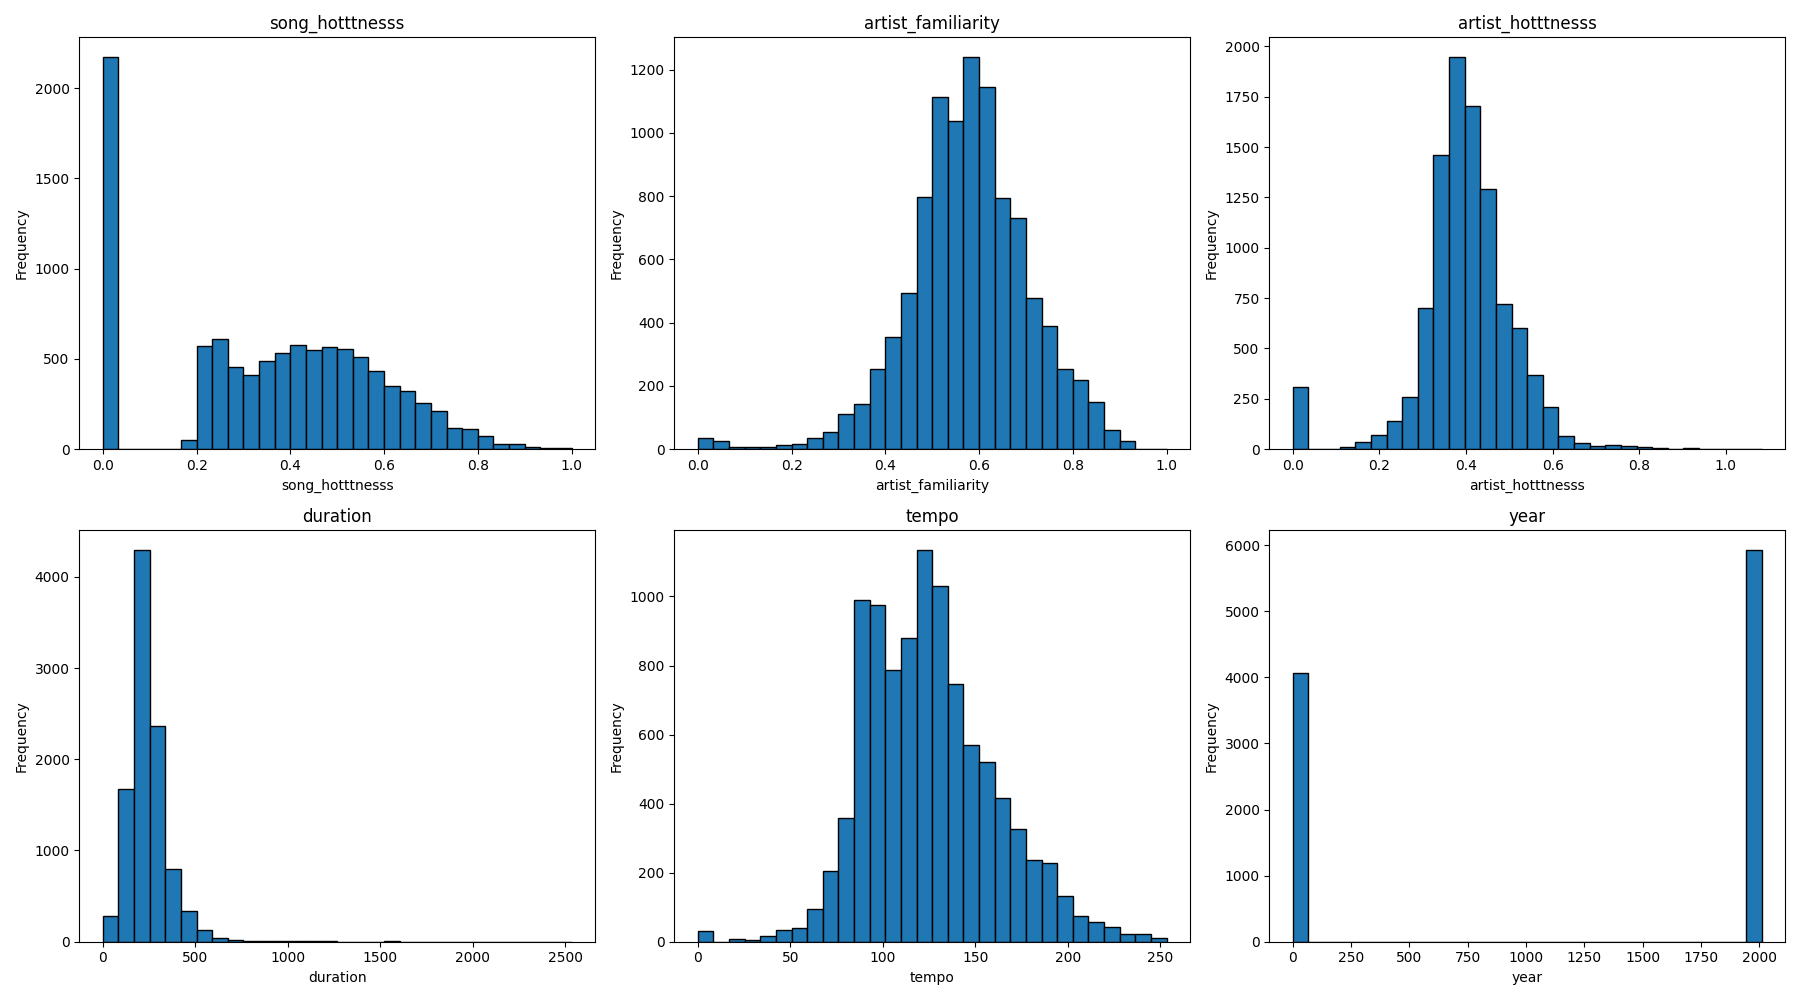

In [8]:
%matplot plt

In [9]:
# Filter out rows where the year is 0
filtered_df = df.filter("year > 0")

# Convert only the 'year' column to Pandas for plotting
pdf_year = filtered_df.select("year").toPandas()

# Plot the histogram of the filtered 'year'
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(pdf_year['year'], bins=30, edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of Year (Filtered: year > 0)")
plt.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

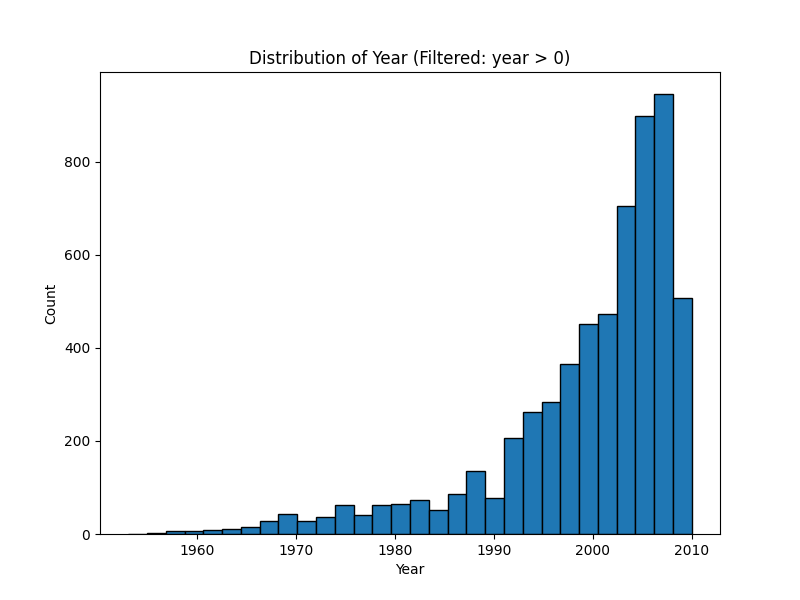

In [10]:
%matplot plt

Some scatter pair plots would also be interesting to see the correlation between features.

✰2.2.1(e) Include the plots of the following pairs of features and describe your findings (e.g. what patterns you observe) in your writeup.

- `song_hotttnesss` against `artist_familiarity`
- `artist_latitude` against `artist_longitude`
- `song_hotttnesss` against `year`

Plotting all data points might explode matplotlib. Think about what simple technique you could use to visualize large datasets while retaining data distribution. ✰2.2.1(f) In your writeup, briefly describe what you did.


In [11]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

# Sample 5% of the data to retain distribution without plotting every point.
# (Adjust the fraction as needed.)
pdf_sample = df.sample(fraction=0.05, seed=42).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].scatter(pdf_sample['song_hotttnesss'], pdf_sample['artist_familiarity'], alpha=0.5, edgecolor='none')
axes[0].set_xlabel('song_hotttnesss')
axes[0].set_ylabel('artist_familiarity')
axes[0].set_title('Song Hotttnesss vs Artist Familiarity')

lat_lon = pdf_sample[['artist_latitude', 'artist_longitude']].dropna()
axes[1].scatter(lat_lon['artist_longitude'], lat_lon['artist_latitude'], alpha=0.5, edgecolor='none')
axes[1].set_xlabel('artist_longitude')
axes[1].set_ylabel('artist_latitude')
axes[1].set_title('Artist Latitude vs Longitude')

axes[2].scatter(pdf_sample['year'], pdf_sample['song_hotttnesss'], alpha=0.5, edgecolor='none')
axes[2].set_xlabel('year')
axes[2].set_ylabel('song_hotttnesss')
axes[2].set_title('Song Hotttnesss vs Year')

plt.tight_layout()
plt.show()
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

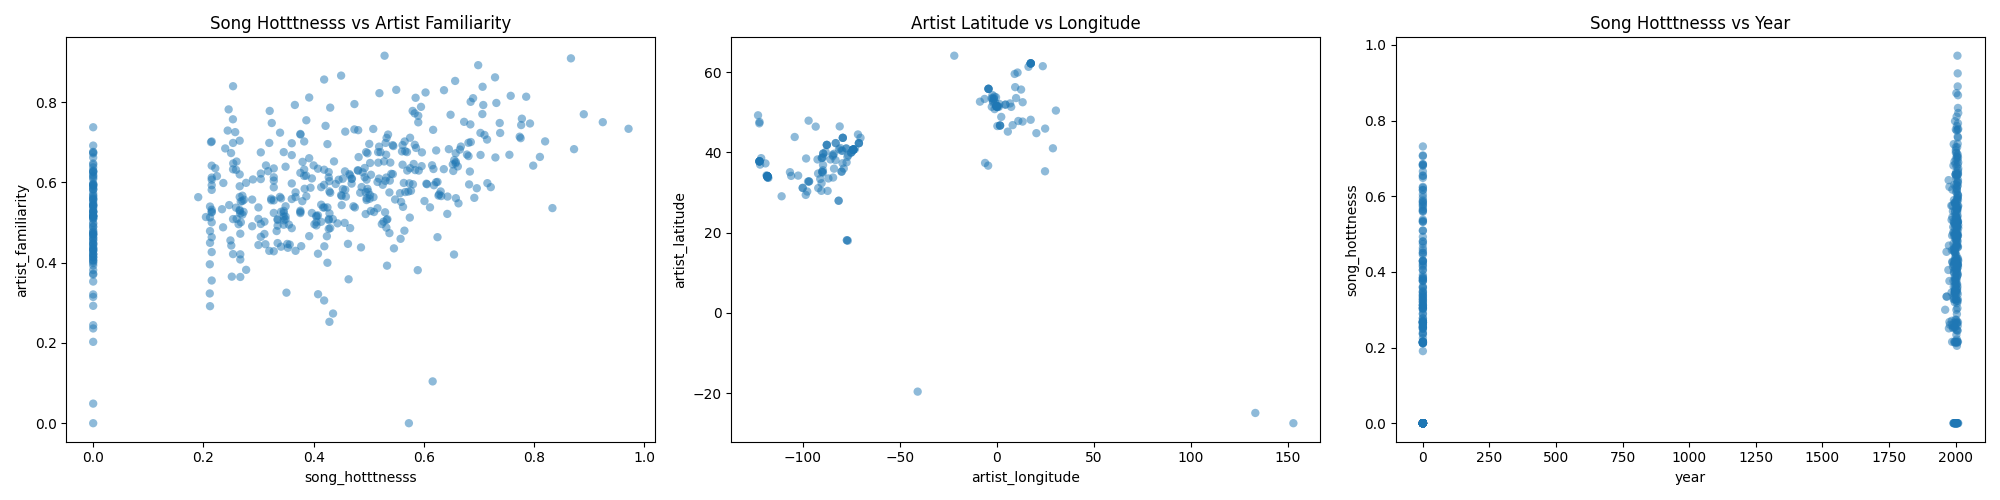

In [12]:
%matplot plt

### 2.2.2 Data Cleaning

From Section 3, you should have had a basic understanding of the dataset. In this cleaning step, we are dropping `energy` and `danceability` features.

✰2.2.2(a) In your writeup, justify why we are doing this.


In [13]:
df_clean = df.drop("energy", "danceability")
df_clean.printSchema()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- artist_te

For simplicity, we are dropping `year` values that are less or equal to 1920. Print out the number of samples before and after dropping these rows.

✰2.2.2(b) In your writeup, compare these two numbers and explain the advantages and potential problem of doing this step. What other techniques could you use to potentially do better?


In [14]:

before_count = df_clean.count()

# Filter out rows with year ≤ 1920
df_filtered = df_clean.filter("year > 1920")

# Count samples after dropping
after_count = df_filtered.count()

print(f"Number of samples before dropping: {before_count}")
print(f"Number of samples after dropping: {after_count}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of samples before dropping: 10000
Number of samples after dropping: 5933

Now, let's do an NaN check to see if there are other problematic features. Print the number of entries that contain NaN for each feature.

Hint: use pyspark sql `count(when(isnull(...)))` to count total Null entries for a feature. Replace `isnull` with `isnan` to count nan entries.


In [15]:
# count na
from pyspark.sql.functions import isnan, when, count, isnull

# YOUR CODE HERE
from pyspark.sql.functions import isnan, when, count, col

# Create a DataFrame with counts of NaN or null for each column
nan_counts = df_clean.select([
    count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c)
    for c in df_clean.columns
])

nan_counts.show(truncate=False)

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+-----------------+---------+---------------+---------------+----------------+-----------+-----+--------+--------------+---+--------------+--------+----+---------------+-----------------+-----+--------------+-------------------------+------------+-----------------+-------------------+----+
|song_hotttnesss|artist_familiarity|artist_hotttnesss|artist_id|artist_latitude|artist_location|artist_longitude|artist_name|title|duration|end_of_fade_in|key|key_confidence|loudness|mode|mode_confidence|start_of_fade_out|tempo|time_signature|time_signature_confidence|artist_terms|artist_terms_freq|artist_terms_weight|year|
+---------------+------------------+-----------------+---------+---------------+---------------+----------------+-----------+-----+--------+--------------+---+--------------+--------+----+---------------+-----------------+-----+--------------+-------------------------+------------+-----------------+-------------------+----+
|0              |0    

We should see two features that contain (a lot of) `nan` in them.

✰2.2.2(c) Which two are they?

For simplicity, we are dropping all records with `nan` in these two features. Note that this drops a significant proportion of our dataset. Since we have a lot of data to fit some rather simple models, this might be ok.

However, do note that this is not usually desirable in the real-word because we always want to retain as much data as possible, especially when training larger, more complex models.

✰2.2.2(d) In your writeup, explain what possible techniques could you employ to deal with this situation. Discuss the pros and cons of your proposed solution.


In [16]:
# YOUR CODE HERE

from pyspark.sql.functions import isnan, when, count, col

# Count NaN values for each column in df_clean.
nan_counts = df_clean.select([
    count(when(isnan(col(c)), c)).alias(c)
    for c in df_clean.columns
])
nan_counts.show(truncate=False)


# YOUR CODE HERE


# Count samples before dropping
before_drop = df_clean.count()

# Filter out rows with NaN in either artist_latitude or artist_longitude.
df_final = df_clean.filter(~(isnan(col("artist_latitude")) | isnan(col("artist_longitude"))))

# Count samples after dropping
after_drop = df_final.count()

print(f"Number of samples before dropping: {before_drop}")
print(f"Number of samples after dropping: {after_drop}")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+-----------------+---------+---------------+---------------+----------------+-----------+-----+--------+--------------+---+--------------+--------+----+---------------+-----------------+-----+--------------+-------------------------+------------+-----------------+-------------------+----+
|song_hotttnesss|artist_familiarity|artist_hotttnesss|artist_id|artist_latitude|artist_location|artist_longitude|artist_name|title|duration|end_of_fade_in|key|key_confidence|loudness|mode|mode_confidence|start_of_fade_out|tempo|time_signature|time_signature_confidence|artist_terms|artist_terms_freq|artist_terms_weight|year|
+---------------+------------------+-----------------+---------+---------------+---------------+----------------+-----------+-----+--------+--------------+---+--------------+--------+----+---------------+-----------------+-----+--------------+-------------------------+------------+-----------------+-------------------+----+
|0              |0    

✰2.2.2(e) Finally in your writeup, report the percentage of records that survived our very aggressive data cleaning.


In [17]:

before_count = df_clean.count()
after_count = df_final.count()

percentage_survived = (after_count / before_count) * 100

print(f"Records before cleaning: {before_count}")
print(f"Records after cleaning: {after_count}")
print(f"Percentage of records that survived cleaning: {percentage_survived:.2f}%")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Records before cleaning: 10000
Records after cleaning: 3610
Percentage of records that survived cleaning: 36.10%

### 2.2.3. Baseline

Now we have the data (almost) ready to do some preliminary modeling!

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average.

✰2.2.3(a) Explain in your writeup why treating this as a classification problem (instead of a regression problem) might be a sensible choice.

Then, assign labels to the dataset with the above definition of "popularity".


In [18]:
from pyspark.sql.functions import col, expr, when

from pyspark.sql.functions import col, when, avg

# Compute the average song_hotttnesss for the dataset.
avg_hotttnesss = df_final.agg(avg("song_hotttnesss")).collect()[0][0]

# Create a new column "popular" where 1 indicates popular (above average) and 0 indicates not popular.
df_labeled = df_final.withColumn(
    "popular",
    when(col("song_hotttnesss") > avg_hotttnesss, 1).otherwise(0)
)

df_labeled.select("song_hotttnesss", "popular").show(5)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-------+
|   song_hotttnesss|popular|
+------------------+-------+
|0.6528356953891383|      1|
|0.5367888864406624|      1|
|0.5654510121736983|      1|
|               0.0|      0|
|               0.0|      0|
+------------------+-------+
only showing top 5 rows

Now let's take a look at how balanced the two classes are.

✰2.2.3(b) Report what percentage of songs are assigned the "popular" label.


In [19]:
from pyspark.sql.functions import col

total_songs = df_labeled.count()
popular_songs = df_labeled.filter(col("popular") == 1).count()

percentage_popular = (popular_songs / total_songs) * 100
print("Percentage of songs assigned the 'popular' label: {:.2f}%".format(percentage_popular))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage of songs assigned the 'popular' label: 52.47%

As how we've been dealing with the `year` feature in earlier assignments, we will shift the feature so that it starts from 0.

✰2.2.3(c) Explain why we want to do this.


In [20]:
from pyspark.sql.functions import col, min

# Compute the minimum year value in the DataFrame.
min_year = df_labeled.agg(min("year")).collect()[0][0]

# Create a new column "year_shifted" where we subtract the minimum year.
df_shifted = df_labeled.withColumn("year_shifted", col("year") - min_year)

# Display the original and shifted year columns.
df_shifted.select("year", "year_shifted").show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------------+
|  year|year_shifted|
+------+------------+
|   0.0|         0.0|
|2006.0|      2006.0|
|2002.0|      2002.0|
|2007.0|      2007.0|
|1968.0|      1968.0|
+------+------------+
only showing top 5 rows

Finally, let's concatenate all features (using VectorAssembler) into a feature vector and scale it.

✰2.2.3(d) Explain what scaling means and why we want to perform scaling before the learning step.

Note: we will only be using the numeric features for now. Excluding `song_hotttnesss` and the two features we dropped in the data cleaning step, there should be 19-3=16 of them.


In [21]:
from pyspark.ml.feature import VectorAssembler

# List of input features (16 numeric features)
input_feature_columns = [
    "artist_familiarity", "artist_hotttnesss", "artist_latitude", "artist_longitude",
    "duration", "end_of_fade_in", "key", "key_confidence", "loudness", "mode",
    "mode_confidence", "start_of_fade_out", "tempo", "time_signature", 
    "time_signature_confidence", "year_shifted"
]

vectorizer = VectorAssembler(inputCols=input_feature_columns, outputCol="features")

df_features = vectorizer.transform(df_shifted)

df_features.printSchema()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- artist_te

In [22]:
from pyspark.ml.feature import StandardScaler

# Create a StandardScaler with input column "features" and output column "scaled_features"
stdscaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Fit the scaler model on the DataFrame
stdscaler_model = stdscaler.fit(df_features)

# Transform the DataFrame to add the scaled features column
df_features = stdscaler_model.transform(df_features)

df_features.select("features", "scaled_features").show(5, truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                           |scaled_features                                                                                                                                                                                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------------------+-------------------

Now let's verify the resulting feature vector is of expected length 16.


In [23]:
# change your variable/column names accordingly
l = df_features.select('features').take(1)[0].features
print('vector len:', len(l))
assert len(l) == 16

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 16

Now, we are really ready to fit some models.

First, do a train-test split on the dataset, with test ratio 0.2 and seed 10605.


In [24]:
# Perform train-test split on the DataFrame
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=10605)

print("Number of training samples:", train_df.count())
print("Number of test samples:", test_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of training samples: 2883
Number of test samples: 727

We have to select a metric to evaluate our models on. For classification, potential choices include accuracy and AUC.

✰2.2.3(e) In your writeup, explain the difference between these two metrics and when AUC might be more useful than accuracy.

We will be going with AUC here. Instantiate an AUC Evaluator in the following cell.


In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate an AUC evaluator. Note: set labelCol to the column name of your binary label.
auc_evaluator = BinaryClassificationEvaluator(labelCol="popular", metricName="areaUnderROC")

# You can later use auc_evaluator.evaluate(predictions) to compute the AUC on a DataFrame of predictions.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest, in the mandatory part. You have the chance go with fancier models in the last section to achieve higher accuracy to earn additional points.

Train a LR and a RF model with default hyperparameters.

✰2.2.3(f) Calculate the train and test AUC of both models and report them in your writeup.


In [26]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# ----- Logistic Regression Model -----
lr = LogisticRegression(featuresCol="scaled_features", labelCol="popular")
lr_model = lr.fit(train_df)

# Make predictions on train and test sets
train_pred_lr = lr_model.transform(train_df)
test_pred_lr = lr_model.transform(test_df)

# Evaluate AUC for Logistic Regression
train_auc_lr = auc_evaluator.evaluate(train_pred_lr)
test_auc_lr = auc_evaluator.evaluate(test_pred_lr)

print("Logistic Regression Train AUC:", train_auc_lr)
print("Logistic Regression Test AUC:", test_auc_lr)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Train AUC: 0.7992174047259589
Logistic Regression Test AUC: 0.7985680879494658

In [27]:
# ----- Random Forest Model -----
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="popular")
rf_model = rf.fit(train_df)

# Make predictions on train and test sets
train_pred_rf = rf_model.transform(train_df)
test_pred_rf = rf_model.transform(test_df)

# Evaluate AUC for Random Forest
train_auc_rf = auc_evaluator.evaluate(train_pred_rf)
test_auc_rf = auc_evaluator.evaluate(test_pred_rf)

print("Random Forest Train AUC:", train_auc_rf)
print("Random Forest Test AUC:", test_auc_rf)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest Train AUC: 0.8316260135151425
Random Forest Test AUC: 0.7969433309037903

### 2.2.4 Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`. In the entity resolution task of HW1, we've seen how TF-IDF could help us featurize textual data. Let's do that here as well. [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) is yet another technique (arguably simpler than TF-IDF) to featurize text features.

To get yourself familiar with both in Spark, let's treat titles and artist terms as mini documents and compute TF-IDF for `title` and BoW for `artist_terms`.


In [28]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5  # You can adjust this value as needed

# Step 1: Tokenize the title column into words.
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
df_tf_idf = tokenizer.transform(df_features)

# Step 2: Compute term frequencies using HashingTF.
hashing = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=TF_IDF_NUM_FEATS)
df_tf_idf = hashing.transform(df_tf_idf)

# Step 3: Fit an IDF model and transform the TF features into TF-IDF features.
idf = IDF(inputCol="title_tf", outputCol="title_tfidf")
idfModel = idf.fit(df_tf_idf)
df_tf_idf = idfModel.transform(df_tf_idf)

# You can now inspect the new TF-IDF features:
df_tf_idf.select("title", "title_tokens", "title_tf", "title_tfidf").show(truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------+-------------------------------------------+-------------------------------------+---------------------------------------------------------------------------------------------------------------+
|title                               |title_tokens                               |title_tf                             |title_tfidf                                                                                                    |
+------------------------------------+-------------------------------------------+-------------------------------------+---------------------------------------------------------------------------------------------------------------+
|Bedroom Acoustics                   |[bedroom, acoustics]                       |(5,[1,2],[1.0,1.0])                  |(5,[1,2],[0.7844223108080407,0.6521811919764273])                                                              |
|Looking For Angels (Album Version)  |[looking, for, angels, (album,

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.


In [29]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5  # Number of features

# Step 1: Tokenize the title column into words.
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
df_tf_idf = tokenizer.transform(df_features)

# Step 2: Compute term frequencies using HashingTF.
hashing = HashingTF(inputCol="title_tokens", outputCol="title_tf", numFeatures=TF_IDF_NUM_FEATS)
df_tf_idf = hashing.transform(df_tf_idf)

# Step 3: Fit an IDF model and transform the TF features into TF-IDF features.
# The output column will be named "title_features"
idf = IDF(inputCol="title_tf", outputCol="title_features")
idfModel = idf.fit(df_tf_idf)
df_tf_idf = idfModel.transform(df_tf_idf)

# Check that the output is as expected.
col_name = 'title_features'
head = df_tf_idf.select(col_name).head()
print(head)
assert type(head[col_name]) == pyspark.ml.linalg.SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_features=SparseVector(5, {1: 0.7844, 2: 0.6522}))

Recall that `artist_terms` should be of type string array but we have not yet interpreted from a string literal. Let's do that now.

Hint: start by defining a UDF to convert a single string literal to type `T.ArrayType(T.StringType())`.


In [30]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T
import ast

def convert_string_of_array_to_array(input_string):
    try:
        # Safely evaluate the string to a Python object.
        output_array = ast.literal_eval(input_string)
        # Ensure that the result is a list; otherwise, return an empty list.
        if isinstance(output_array, list):
            return output_array
        else:
            return []
    except Exception:
        return []

# Define the UDF with the desired return type.
convert_string_of_array_to_array_udf = udf(convert_string_of_array_to_array, T.ArrayType(T.StringType()))

# Apply the UDF to the "artist_terms" column, converting it from a string literal to an array.
df_tags_arr = df_tf_idf.withColumn("artist_terms", convert_string_of_array_to_array_udf("artist_terms"))

df_tags_arr.select("artist_terms").show(truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artist_terms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Let's do a quick check things indeed worked out.


In [31]:
# Convert "artist_terms" to an array and store it in a new column "artist_terms_arr"
df_tags_arr = df_tf_idf.withColumn("artist_terms_arr", convert_string_of_array_to_array_udf("artist_terms"))

col_name = 'artist_terms_arr'
head = df_tags_arr.select(col_name).head()
print(head)
assert type(head[col_name]) == list


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_arr=['art rock', 'piano rock', 'indie pop', 'alternative rock', 'progressive rock', 'alternative pop rock', 'emo', 'hard rock', 'indie rock', 'grunge', 'ballad', 'post rock', 'alternative metal', 'pop rock', 'male vocalist', 'heavy metal', 'rock', 'psychedelic rock', 'new wave', 'electronica', 'alternative', 'soundtrack', 'indie', '00s', 'progressive', 'electronic', 'experimental', 'rap', 'punk', 'pop', 'jazz', 'metal'])

Now perform BoW on the array feature you just created.

✰2.2.4(a) In your writeup, explain what the `vocabSize` hyperparameter means in the context of Bag-of-Words. Remember you can tune this later in the last section.


In [32]:
from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10
BOW_MIN_DF = 2

# Create a CountVectorizer with the input column "artist_terms" and output column "artist_terms_bow"
cv = CountVectorizer(inputCol="artist_terms", outputCol="artist_terms_bow", 
                     vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)

# Fit the model on the DataFrame
cv_model = cv.fit(df_final)

# Transform the DataFrame to include the new BoW features column
df_final = cv_model.transform(df_final)

# Optionally, inspect the result
df_final.select("artist_terms", "artist_terms_bow").show(5, truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
requirement failed: Column artist_terms must be of type equal to one of the following types: [array<string>, array<string>] but was actually of type string.
Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/pyspark.zip/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 379, in _fit
    java_model = self._fit_java(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 376, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 13

Verify the result of BoW is indeed a vector of length `BOW_VOCAB_SIZE`.


✰2.2.4(b) Other than featurizing texts, what other feature engineering would you do on the dataset? Briefly describe one in your writeup.


Now with the new feature columns ready, let's assemble and scale our features once again as we did to prepare for training.

This time, we should have 16 features, plus the features we just created from TF-IDF and BoW. The total length of the resulting feature vector should be 31.

✰2.2.4(c) Explain where this number (31) comes from in your writeup.


In [33]:
from pyspark.ml.feature import VectorAssembler

# List of 16 numeric features (excluding song_hotttnesss and the dropped features)
input_feature_columns = [
    "artist_familiarity", "artist_hotttnesss", "artist_latitude", "artist_longitude",
    "duration", "end_of_fade_in", "key", "key_confidence", "loudness", "mode",
    "mode_confidence", "start_of_fade_out", "tempo", "time_signature",
    "time_signature_confidence", "year_shifted"
]

# Create a VectorAssembler to combine the features into one column "features"
vectorizer = VectorAssembler(inputCols=input_feature_columns, outputCol="features")

# Transform the DataFrame to include the new feature vector column.
df_final = vectorizer.transform(df_final)

# Optionally, inspect the schema to confirm the new column is added.
df_final.printSchema()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
year_shifted does not exist. Available: song_hotttnesss, artist_familiarity, artist_hotttnesss, artist_id, artist_latitude, artist_location, artist_longitude, artist_name, title, duration, end_of_fade_in, key, key_confidence, loudness, mode, mode_confidence, start_of_fade_out, tempo, time_signature, time_signature_confidence, artist_terms, artist_terms_freq, artist_terms_weight, year
Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/pyspark.zip/pyspark/ml/base.py", line 262, in transform
    return self._transform(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182129057_0007_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 396, in _transform
    return DataFrame(self._java_obj.transform(dataset._jdf), dataset.sparkSession)
  File "/mnt1/yarn/usercache/livy/appcache/application_1740182129057_0007/container_1740182

In [34]:
# scaling

# YOUR CODE HERE
stdscaler = StandardScaler(inputCol="<FILL IN>", outputCol="<FILL IN>")
stdscaler_model = stdscaler.<FILL IN>

df_scaled_features = stdscaler_model.<FILL IN>


# YOUR CODE HERE
df_scaled_features.toPandas().head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
invalid syntax (<stdin>, line 5)
  File "<stdin>", line 5
    stdscaler_model = stdscaler.<FILL IN>
                                ^
SyntaxError: invalid syntax



Now let's verify the feature vector is of expected length 31.


In [35]:
# change your variable/column names accordingly
l = df_scaled_features.select('features').take(1)[0].features
print('vector len:', len(l))
assert len(l) == 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'df_scaled_features' is not defined
Traceback (most recent call last):
NameError: name 'df_scaled_features' is not defined



### 2.2.5 Modeling with New Features


Now let's fit LR and RF on our new data. As before, first do a train-test split with test ratio 0.2 and seed 10605.


In [36]:
# YOUR CODE HERE

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now train the LR and RF model with default hyperparameters.

✰2.2.5(a) Evaluate train and test AUC for each model and report them in your writeup.


In [37]:
# Logistic Regression

# YOUR CODE HERE

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# Random Forest

# YOUR CODE HERE

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Recall that AUC is the area under the ROC curve. Now, plot the ROC curves for the four models (including two baselines) in **one single plot**.

✰2.2.5(b) In your writeup:

- Include the plot (with legends)
- Explain how the ROC curve is derived and what it measures
- Explain, from the ROC curves, how do you discover which models are performing better than others, and in this case, which model performs the best.


In [39]:
# YOUR CODE HERE

# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
def get_tpr_fpr(test_df):
    label_and_prob = test_df.select('popularlity', 'probability').rdd.map(
        lambda row: (float(row['popularlity']), float(row['probability'][1]))).collect()
    label_and_prob.sort(key=lambda x: x[1], reverse=True)
    labels_by_weight = np.array([k for (k, v) in label_and_prob])

    length = labels_by_weight.size
    true_positives = labels_by_weight.cumsum()
    num_positive = true_positives[-1]
    false_positives = np.arange(1.0, length + 1, 1.) - true_positives

    true_positive_rate = true_positives / num_positive
    false_positive_rate = false_positives / (length - num_positive)

    return true_positive_rate, false_positive_rate

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# YOUR CODE HERE
pr_lr_baseline, fpr_lr_baseline = get_tpr_fpr(<FILL IN>)
tpr_rf_baseline, fpr_rf_baseline = get_tpr_fpr(<FILL IN>)
tpr_lr, fpr_lr = get_tpr_fpr(<FILL IN>)
tpr_rf, fpr_rf = get_tpr_fpr(<FILL IN>)
# YOUR CODE HERE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
invalid syntax (<stdin>, line 2)
  File "<stdin>", line 2
    pr_lr_baseline, fpr_lr_baseline = get_tpr_fpr(<FILL IN>)
                                                  ^
SyntaxError: invalid syntax



In [42]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels:
            axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(fpr_lr_baseline, tpr_lr_baseline, color='r', label="LogisticRegressionBaseline")
plt.plot(fpr_rf_baseline, tpr_rf_baseline, color='g', label="RandomForestBaseline")
plt.plot(fpr_lr, tpr_lr, color='b', label="LogisticRegression")
plt.plot(fpr_rf, tpr_rf, color='orange', label="RandomForest")
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2',
         linewidth=2., label="baseline")  # Baseline model
plt.legend()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'fpr_lr_baseline' is not defined
Traceback (most recent call last):
NameError: name 'fpr_lr_baseline' is not defined



### 2.2.6 Do Your Best


In all previous sections in this assignment and other assignments so far, we have almost specified everything you should do. You might be (and should be!) bored by now. This section gives you a chance to do whatever you want to improve the prediction AUC.

You can do better data preprocessing, feature engineering, fit fancier models, perform hyperparameter tuning, etc.

✰2.2.6 after you are satisfied with your model, report in your writeup

- the hyperparameters,
- train and test AUC of your optimized model, and
- the approach you took on top of the specified instructions to obtain this better result.


In [44]:
# have fun!

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.2.7 Don't forget to answer the reflection question on the writeup! ✰2.2.7
